In [1]:
import os
import csv
from collections import Counter

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator

METADATA_DIR = "Metadata"
MUTSUMMARY_DIR = "MutSummary"
PLOTS_DIR = os.path.join("..", "Output")

REFERENCE = 'EPI_ISL_402125'

In [2]:
background = pd.read_csv(os.path.join(METADATA_DIR, "SARS_CoV_2.csv"), index_col=0)

background['date'] = pd.to_datetime(background['date'], errors='coerce')
background = background.dropna()

background = background[background["host"] == "Human"]

# background['Compare'] = 'Global'
# background.loc[background['region'] == 'Europe', 'Compare'] = 'Europe'

In [3]:
background

,region_exposure,country_exposure,date,host,pangolin_lineage,Nextstrain_clade,GISAID_clade
gisaid_epi_isl,,,,,,,
EPI_ISL_754239,Asia,Indonesia,2020-07-20,Human,B,19A,O
EPI_ISL_418241,Africa,Algeria,2020-03-02,Human,B.1,20C,GH
EPI_ISL_418242,Africa,Algeria,2020-03-08,Human,B.1,20C,GH
EPI_ISL_420037,Africa,Algeria,2020-03-02,Human,B.1,20C,GH
EPI_ISL_766868,Africa,Algeria,2020-06-01,Human,B.1,20A,G
...,...,...,...,...,...,...,...
EPI_ISL_644819,Africa,Zimbabwe,2020-06-01,Human,B.1.1,20B,GR
EPI_ISL_644767,Africa,Zimbabwe,2020-06-01,Human,B.1.1,20B,GR
EPI_ISL_644820,Africa,Zimbabwe,2020-06-01,Human,B.1.1,20B,GR


In [4]:
animal = 'Human'

df = []

for folderName in os.listdir(os.path.join(MUTSUMMARY_DIR, animal)):
    mutBase = folderName.split('_')[2][-1]
#     mutName = folderName.split('_')[1]
    siteName = int(folderName.split('_')[2][1:-1])
    print(siteName)
    proteinName = folderName.split('_')[0]
    for fileName in os.listdir(os.path.join(MUTSUMMARY_DIR, animal, folderName)):
        if fileName.startswith(mutBase):
            if fileName.endswith('trans.csv'):
                filePath = os.path.join(MUTSUMMARY_DIR, animal, folderName, fileName)
                with open(filePath) as f:
                    ac = []
                    for row in f:
                        row = row.strip()
                        if row in background.index:
                            ac.append(row)
                    if len(ac):
                        hasMut = background.loc[ac].copy()
                        hasMut['Mut'] = folderName
                        hasMut['protein'] = proteinName
                        hasMut['Base'] = fileName[0]
                        hasMut['site'] = siteName
                        df.append(hasMut)
            elif fileName.endswith('trans_meta.csv'):
                filePath = os.path.join(MUTSUMMARY_DIR, animal, folderName, fileName)
                mutInfo = pd.read_csv(filePath, index_col=0)
                if len(mutInfo):
                    ac = []
                    for i in mutInfo.index:
                        if i in background.index:
                            ac.append(i)
                    hasMut = background.loc[ac].copy()
                    hasMut['Mut'] = folderName
                    hasMut['protein'] = proteinName
                    hasMut['Base'] = fileName[0]
                    hasMut['site'] = siteName
                    df.append(hasMut)

df = pd.concat(df)
df = df.sort_values("site")
# df[['Year', "Month", "Day"]] = df['date'].str.split('-', expand=True)
# df['Date_str'] = df['Date']
# df['Date'] = pd.to_datetime(df['date'], errors='coerce')
# df = df.dropna()
# df = df.sort_values('Date')
df = df.reset_index(drop=True)

# df['Compare'] = 'Global'
# df.loc[df['Region'] == 'Europe', 'Compare'] = 'Europe'

# for ac, acInfo in df.groupby('gisaid_epi_isl'):
#     haplo = ', '.join(acInfo['Mut'])
#     df.loc[df['gisaid_epi_isl'] == ac, 'Haplotype'] = haplo

15766
1163
10323
11083
28883
28975
28869
28472
28881
28854
28887
25563
23664
23403
21801
23012
23063
22992


In [5]:
colors = ["#65D640", '#1CA4FC', '#D12177', '#FD97CA', '#F7B92B', '#FC291C', '#000080']
proteins = df['protein'].unique()
colors = dict(i for i in zip(proteins, colors))

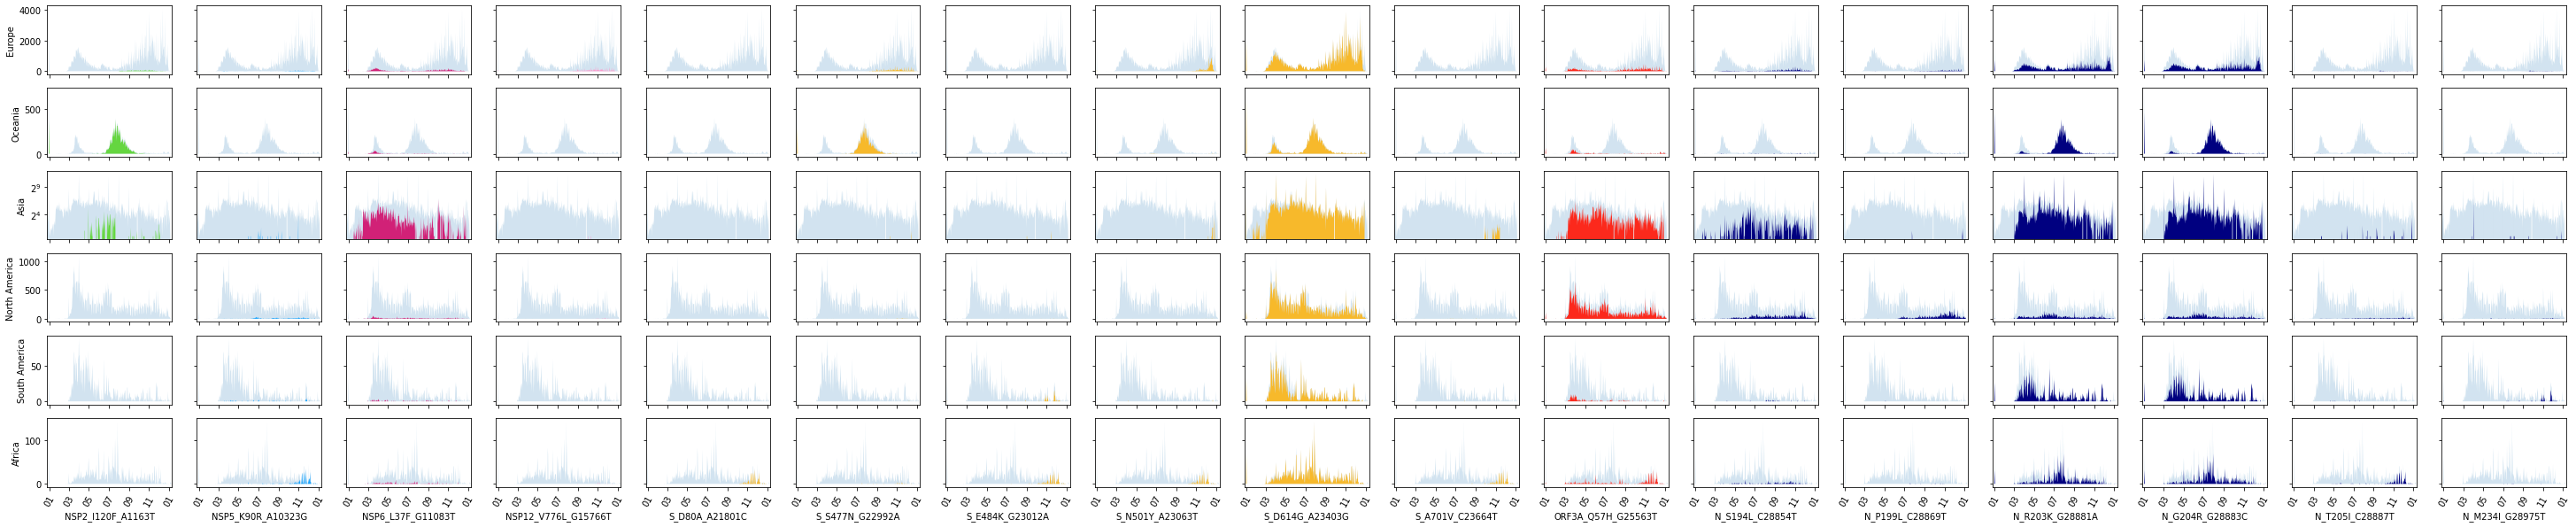

In [7]:
regions = df["region_exposure"].unique()
sites = [sInfo["Mut"].unique()[0] for s, sInfo in df[["Mut", "site"]].groupby("site")]
# sites[1], sites[-2] = sites[-2], sites[1]

nregion = len(regions)
nsites = len(sites)

fig, axes = plt.subplots(
    nregion,
    nsites,
    sharex=True,
    sharey='row',
    figsize = (3 * nsites, 10)
)

x_pos = background['date'].unique()
x_pos.sort()
x_pos = pd.to_datetime(x_pos)

for i in range(nsites):
    site = sites[i]
    proteinName = site.split('_')[0]
    siteInfo = df.loc[df['Mut'] == site]
    for j in range(nregion):
        region = regions[j]
        bg = background.loc[background['region_exposure'] == region, 'date'].value_counts()
        s = siteInfo.loc[siteInfo['region_exposure'] == region, 'date'].value_counts()
        nbg = []
        bgSum = 0
        ns = []
        nSum = 0
        nRatio = []
        for d in x_pos:
            if d in bg.index:
                bgNum = bg[d]
            else:
                bgNum = 0
            bgSum += bgNum
            nbg.append(bgNum)
#             nbg.append(bgSum)
            
            if d in s.index:
                sNum = s[d]
            else:
                sNum = 0
            nSum += sNum
            ns.append(sNum)
#             ns.append(nSum)
        ax = axes[j][i]
        ax.fill_between(x_pos, 0, nbg, alpha=0.2, label='total')
        ax.fill_between(x_pos, 0, ns, label = proteinName, facecolor=colors[proteinName])
        if region == "Asia":
            ax.set_yscale('log', base=2)
        ax.tick_params(axis='x', labelrotation=60)
        ax.set_xlim([x_pos[1], x_pos[-1]])
        ax.xaxis.set_major_formatter(DateFormatter('%m'))
        if j == nregion - 1:
            ax.set_xlabel(site)
        if i == 0:
            ax.set_ylabel(region)
#             if i == 0:
#                 axes[i][j].legend(loc='upper left')
                
plt.savefig(os.path.join(PLOTS_DIR, "sites.pdf"), bbox_inches="tight")
plt.show()

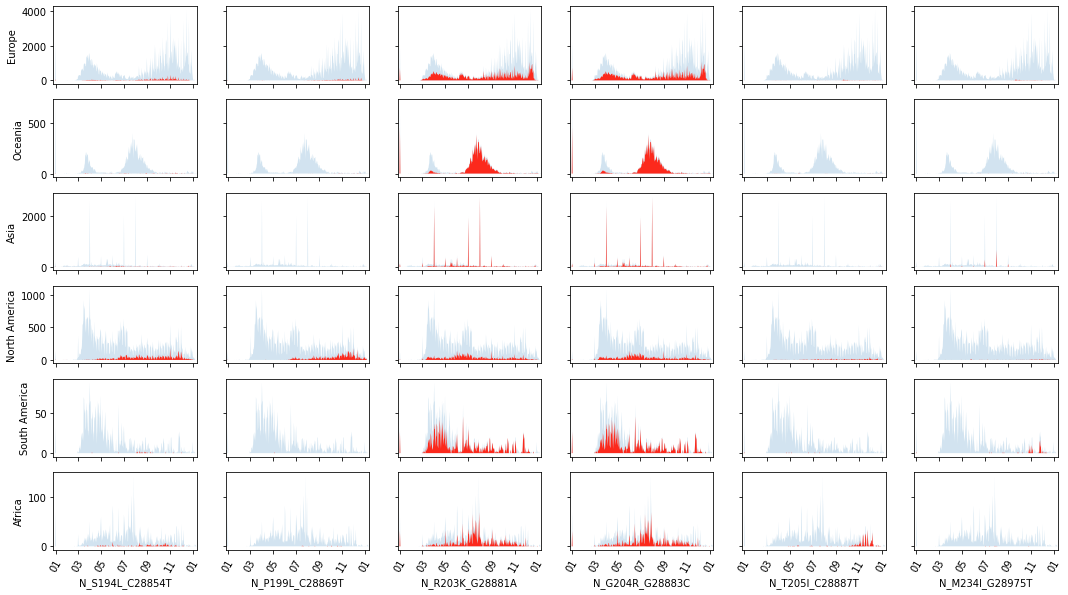

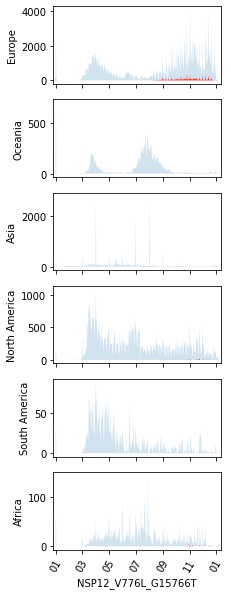

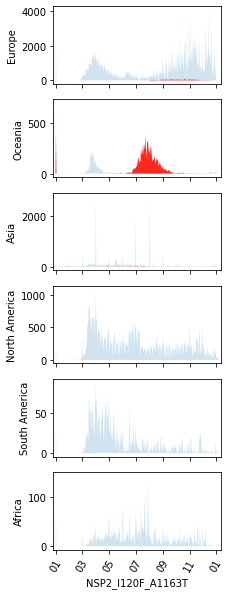

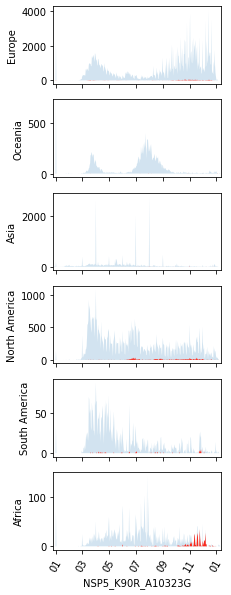

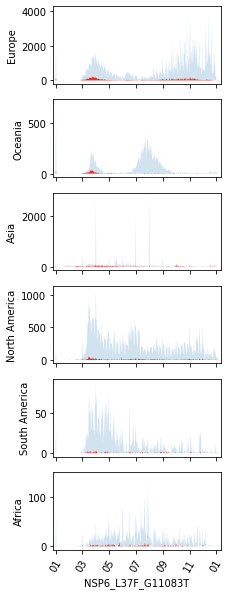

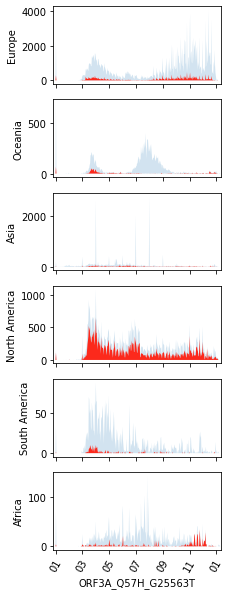

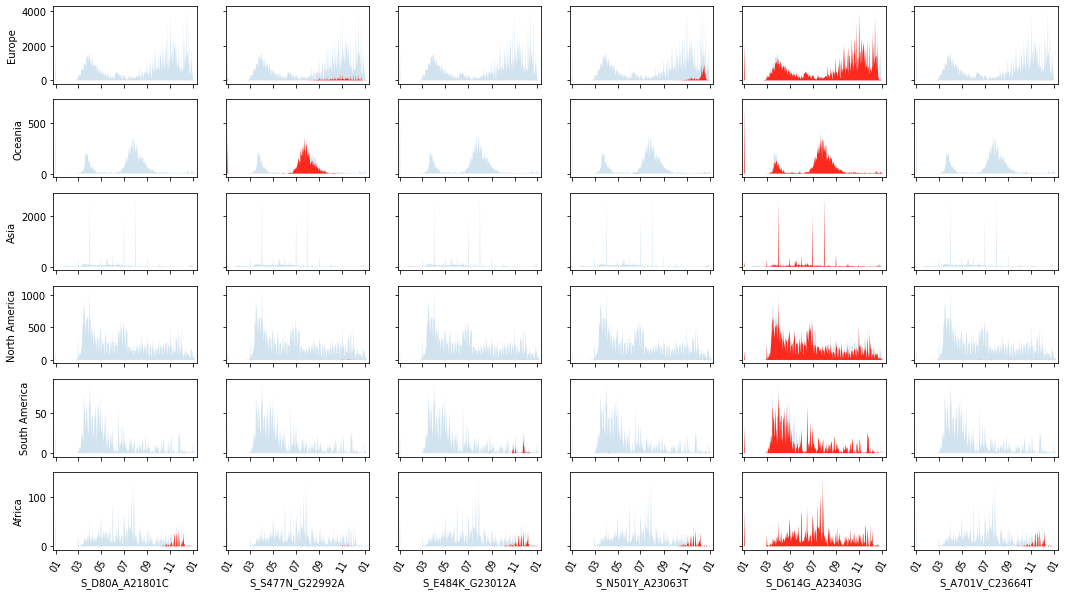

In [8]:
color = '#FC291C'
regions = df["region_exposure"].unique()

for protein, proteinInfo in df.groupby('protein'):
#     regions = proteinInfo["region_exposure"].unique()
    sites = [sInfo["Mut"].unique()[0] for s, sInfo in proteinInfo[["Mut", "site"]].groupby("site")]
#     sites[1], sites[-2] = sites[-2], sites[1]

    nregion = len(regions)
    nsites = len(sites)

    fig, axes = plt.subplots(
        nregion,
        nsites,
        sharex=True,
        sharey='row',
        figsize = (3 * nsites, 10)
    )

    x_pos = background['date'].unique()
    x_pos.sort()
    x_pos = pd.to_datetime(x_pos)

    for i in range(nsites):
        site = sites[i]
        proteinName = site.split('_')[0]
        siteInfo = proteinInfo.loc[proteinInfo['Mut'] == site]
        for j in range(nregion):
            region = regions[j]
            bg = background.loc[background['region_exposure'] == region, 'date'].value_counts()
            s = siteInfo.loc[siteInfo['region_exposure'] == region, 'date'].value_counts()
            nbg = []
            bgSum = 0
            ns = []
            nSum = 0
            nRatio = []
            for d in x_pos:
                if d in bg.index:
                    bgNum = bg[d]
                else:
                    bgNum = 0
                bgSum += bgNum
                nbg.append(bgNum)
    #             nbg.append(bgSum)

                if d in s.index:
                    sNum = s[d]
                else:
                    sNum = 0
                nSum += sNum
                ns.append(sNum)
            if nsites > 1:
                ax = axes[j][i]
            else:
                ax = axes[j]
            ax.fill_between(x_pos, 0, nbg, alpha=0.2, label='total')
            ax.fill_between(x_pos, 0, ns, label = proteinName, facecolor=color)
    #         ax.set_yscale('log', base=2)
            ax.tick_params(axis='x', labelrotation=60)
            ax.set_xlim([x_pos[1], x_pos[-1]])
            ax.xaxis.set_major_formatter(DateFormatter('%m'))
            if j == nregion - 1:
                ax.set_xlabel(site)
            if i == 0:
                ax.set_ylabel(region)
    #             if i == 0:
    #                 axes[i][j].legend(loc='upper left')
    plt.savefig(os.path.join(PLOTS_DIR, protein + ".pdf"), bbox_inches="tight")
    plt.show()